# **Assignment 1**

## **Team members:**
### Mirco Lescart
### Freddy Fernandes
### Parsa Mastouri Kashani
### Arina Sadeghi Khiabanian

# Task 1
First, we install packages and necessary libraries

---



In [1]:
import os
import shutil
import urllib
import tarfile
import sys

import matplotlib.pyplot as plt
# data and numerical management packages
import pandas as pd
import numpy as np
import gensim.downloader as gloader

# useful during debugging (progress bars)
from tqdm import tqdm

# typing
from typing import List, Callable, Dict

## Dataframe creation

In [2]:
import zipfile

data_zip_file_path = 'dependency_treebank.zip'
data_output_folder = 'data'

with zipfile.ZipFile(data_zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(data_output_folder)

In [3]:
directory_path = './data/dependency_treebank'
dp_files = [file for file in os.listdir(directory_path) if file.endswith('.dp')]

data_frames = []

for file in dp_files:
    with open(os.path.join(directory_path, file), 'r') as f:
        lines = f.readlines()
        data = [line.strip().split('\t')[:2] for line in lines]
        df = pd.DataFrame(data, columns=['Word', 'POS'])
        df["Word"] = df.Word.str.lower()
        df = df[df["Word"] != ""]  # drop empty rows
        data_frames.append(df)

# Create a MultiIndex DataFrame to represent the origin of each row
df = pd.concat(data_frames, keys=range(1, 201), names=['Source File'])

### Split the data to training,validation and test sets

In [4]:
# Add a "Split" column with default values
df['Split'] = 'training'

df.loc[101:150, 'Split'] = 'validation'
df.loc[151:200, 'Split'] = 'test'


In [5]:
df.head()

Word  POS     Split
Source File                           
1           0  carnival  NNP  training
            1    cruise  NNP  training
            2     lines  NNP  training
            3      inc.  NNP  training
            4      said  VBD  training

# Task 2


## Length normalisation

The inputs must have the same length/dimension. There are two options:
- Set all the inputs length to the biggest length, but dimension will maybe be a little too long.
- Choose an arbitrary length, but some inputs will be truncated.



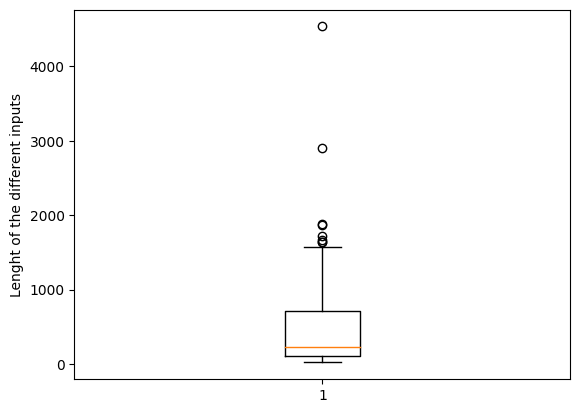

In [6]:
lenghts = [len(df.loc[i]["Word"]) for i in range(1, 200)]

plt.boxplot(lenghts)
plt.ylabel("Lenght of the different inputs")
plt.show()


We can see on the graph that the lengths are too sparse $\rightarrow$ Work on sentences instead of text.

In [7]:
numb_sentences_by_set = {"training": 0,
                         "validation": 0,
                         "test": 0}

sentences_list = []  # list of all sentences [[sentence 1], [sentences 2], ...]
pos_list = []

sent = []
pos = []
for i in range(df.shape[0]):
    word = df["Word"].iloc[i]
    pos_word = df["POS"].iloc[i]

    sent.append(word)
    pos.append(pos_word)

    if pos_word == "." or word == "..." or word == ";":
        sentences_list.append(sent)
        pos_list.append(pos)
        sent = []
        pos = []
        numb_sentences_by_set[df["Split"].iloc[i]] += 1

numb_sentences = len(sentences_list)



In [8]:
print(f"Number of sentences by set : {numb_sentences_by_set}")

Number of sentences by set : {'training': 1987, 'validation': 1128, 'test': 946}


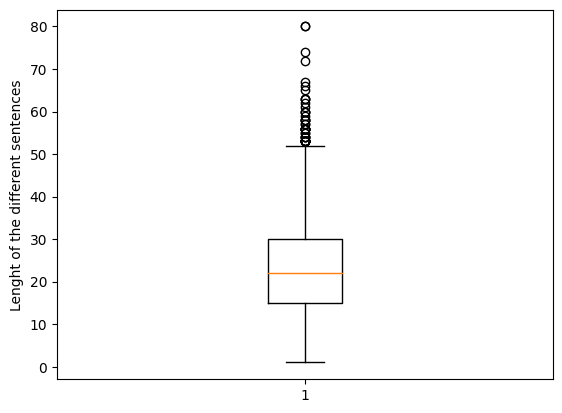

In [9]:
lengths_sent = [len(sent) for sent in sentences_list]
plt.boxplot(lengths_sent)
plt.ylabel("Length of the different sentences")
plt.show()

We can concatenate the sentences in a format of a length of 80

So if length<80, then we have to fill the sentence with empty word which will be defined as "\BLANK\". And if length>80, remove last words.

In [10]:
def set_length(sentence, target_length):
    while len(sentence) < target_length:
        sentence.append("<pad>")
    return sentence[:target_length]

In this cell:

1)we Create a new dataframe where each element df.loc[i] is a sentence of length equal to 80

2)Create a MultiIndex DataFrame to represent the origin of each row


In [11]:
max_length = 80

data_frames = []
for i in range(numb_sentences):
    data = {'Word': set_length(sentences_list[i], max_length), 'POS': set_length(pos_list[i], max_length)}

    df2 = pd.DataFrame(data)
    data_frames.append(df2)
print(f"Number of sentences = {len(data_frames)}")


df = pd.concat(data_frames, keys=range(numb_sentences), names=['Sentences'])

# data_frames=[] To not store it (I'm not in computer sciences so idk if it's useful)

Number of sentences = 4061


In [12]:
df

Word    POS
Sentences                    
0         0   carnival    NNP
          1     cruise    NNP
          2      lines    NNP
          3       inc.    NNP
          4       said    VBD
...                ...    ...
4060      75     <pad>  <pad>
          76     <pad>  <pad>
          77     <pad>  <pad>
          78     <pad>  <pad>
          79     <pad>  <pad>

[324880 rows x 2 columns]

## Tokenization

In [13]:
from keras.preprocessing.text import Tokenizer

#tokenizer for words 
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(df["Word"])
word_encoded = word_tokenizer.texts_to_sequences(df["Word"])

#tokenizer for pos
pos_tokenizer = Tokenizer()
pos_tokenizer.fit_on_texts(df["POS"])
pos_encoded = pos_tokenizer.texts_to_sequences(df["POS"])


In [14]:
print(list(df["Word"][:25]))
print(word_encoded[:25])
print()
print(list(df["POS"][:25]))
print(pos_encoded[:25])


['carnival', 'cruise', 'lines', 'inc.', 'said', 'potential', 'problems', 'with', 'the', 'construction', 'of', 'two', 'big', 'cruise', 'ships', 'from', 'finland', 'have', 'been', 'averted', '.', '<pad>', '<pad>', '<pad>', '<pad>']
[[1155], [2056], [1585], [81], [13], [777], [395], [19], [2], [354], [3], [74], [131], [2056], [1586], [20], [2912], [30], [65], [5276], [], [1], [1], [1], [1]]

['NNP', 'NNP', 'NNP', 'NNP', 'VBD', 'JJ', 'NNS', 'IN', 'DT', 'NN', 'IN', 'CD', 'JJ', 'NN', 'NNS', 'IN', 'NNP', 'VBP', 'VBN', 'VBN', '.', '<pad>', '<pad>', '<pad>', '<pad>']
[[4], [4], [4], [4], [9], [7], [6], [3], [5], [2], [3], [8], [7], [2], [6], [3], [4], [18], [15], [15], [], [1], [1], [1], [1]]


We can see the different words being marked as different parts of speech

The encoder doesn't make a difference between comma, point, etc... Furthermore, the word "n.v." isn't associated to one integer.

So $\rightarrow$ Vocabulary

In [15]:
from collections import OrderedDict

# Function to create a vocabulary mapping of words to indices and vice versa.
def build_vocabulary(word_list):
    idx_to_word = OrderedDict() # Create an ordered dictionary for index-to-word mapping.
    word_to_idx = OrderedDict() # Create an ordered dictionary for word-to-index mapping.

    word_to_idx["<pad>"] = 0 # Initialize the dictionary with a padding token.
    idx_to_word[0] = "<pad>"

    curr_idx = 1
    for token in tqdm(word_list):
        if token not in word_to_idx:
            word_to_idx[token] = curr_idx
            idx_to_word[curr_idx] = token
            curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

In [16]:
# Use the function to build vocabularies from a DataFrame column 'Word'.
idx_to_word, word_to_idx, word_listing = build_vocabulary(df["Word"])
print(f'[Debug] Index -> Word vocabulary size: {len(idx_to_word)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word_to_idx)}')
print(f'[Debug] Some words: {[(idx_to_word[idx], idx) for idx in np.arange(10) + 1]}')

100%|██████████| 324880/324880 [00:00<00:00, 1344404.60it/s]

[Debug] Index -> Word vocabulary size: 10948
[Debug] Word -> Index vocabulary size: 10948
[Debug] Some words: [('carnival', 1), ('cruise', 2), ('lines', 3), ('inc.', 4), ('said', 5), ('potential', 6), ('problems', 7), ('with', 8), ('the', 9), ('construction', 10)]


In [17]:
# Use the function to build vocabularies from a DataFrame column 'POS' (Part of Speech).
idx_to_pos, pos_to_idx, pos_listing = build_vocabulary(df["POS"])
print(f'[Debug] Index -> pos vocabulary size: {len(idx_to_pos)}')
print(f'[Debug] pos -> Index vocabulary size: {len(pos_to_idx)}')
print(f'[Debug] Some poss: {[(idx_to_pos[idx], idx) for idx in np.arange(10) + 1]}')

100%|██████████| 324880/324880 [00:00<00:00, 1452924.39it/s]

[Debug] Index -> pos vocabulary size: 46
[Debug] pos -> Index vocabulary size: 46
[Debug] Some poss: [('NNP', 1), ('VBD', 2), ('JJ', 3), ('NNS', 4), ('IN', 5), ('DT', 6), ('NN', 7), ('CD', 8), ('VBP', 9), ('VBN', 10)]


In [18]:
# Replace words in the DataFrame with their respective indices.
df["Word"] = [word_to_idx[df["Word"].iloc[i]] for i in range(df.shape[0])]
# Replace POS tags in the DataFrame with their respective indices.
df["POS"] = [pos_to_idx[df["POS"].iloc[i]] for i in range(df.shape[0])]

In [19]:
df

Word  POS
Sentences              
0         0      1    1
          1      2    1
          2      3    1
          3      4    1
          4      5    2
...            ...  ...
4060      75     0    0
          76     0    0
          77     0    0
          78     0    0
          79     0    0

[324880 rows x 2 columns]

### Split
**Store in numpy array to avoid an error**

In [20]:
from keras.utils import to_categorical

# Extracting word and POS tags and converting them to numpy arrays.
X = np.array([df.Word.loc[i] for i in range(numb_sentences)])
Y = np.array([df.POS.loc[i] for i in range(numb_sentences)])

# Converting the POS tags to one-hot encoded format.
Y = to_categorical(Y)

In [21]:
numb_sentences_by_set

{'training': 1987, 'validation': 1128, 'test': 946}

In [22]:
# Splitting the dataset into training, validation, and test sets based on predefined counts.
train_end = numb_sentences_by_set["training"]
validation_end = train_end + numb_sentences_by_set["validation"]
test_end = validation_end + numb_sentences_by_set["test"]

# Creating training, validation, and test datasets.
X_train, Y_train = X[0:train_end], Y[0:train_end]

X_validation, Y_validation = X[train_end: validation_end], Y[train_end: validation_end]

X_test, Y_test = X[validation_end: test_end], Y[validation_end: test_end]


In [23]:
# Printing the shapes of the input and output sequences for each dataset.
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-" * 50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-" * 50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (1987, 80)
Shape of output sequences: (1987, 80, 46)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (1128, 80)
Shape of output sequences: (1128, 80, 46)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (946, 80)
Shape of output sequences: (946, 80, 46)


## GloVe embeddings

In [24]:
# Taken from Lab 2

import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")

    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [25]:
embedding_dimension = 100
embedding_model = load_embedding_model(model_type="glove",
                                       embedding_dimension=embedding_dimension)

[==================================================] 100.0% 128.1/128.1MB downloaded


In [26]:
voc_size = len(word_listing)

# create an empty embedding matrix
embedding_weights = np.zeros((voc_size, embedding_dimension))

# copy vectors from glove model to the words present in corpus
for word, index in word_to_idx.items():
    try:
        embedding_weights[index, :] = embedding_model[word]
    except KeyError:
        pass

### OOV Words

Check if the pre-trained embedding cover enough of our vocab

In [27]:
print("Total number of words: {}".format(len(df["Word"])))
print("Vocabulary size: {}".format(len(word_listing)))

Total number of words: 324880
Vocabulary size: 10948


In [28]:
# Taken from Lab 2
def check_OOV_terms(embedding_model, word_listing):
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)


# TODO : only check for OOV in the validation and test set
word_listing_val_test = [idx_to_word[word] for word in df.loc[train_end:, "Word"]]
word_listing_val_test = build_vocabulary(word_listing_val_test)[2]

oov_terms = check_OOV_terms(embedding_model, word_listing_val_test)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing_val_test)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")



100%|██████████| 165920/165920 [00:00<00:00, 3471176.99it/s]

Total OOV terms: 367 (5.16%)


**In this code,we tried to assign a static embedding and also print the number of words without Glove embedding**

In [29]:
embedding_weights = np.zeros((voc_size, embedding_model.vector_size))

for word, index in word_to_idx.items():
    try:
        embedding_weights[index, :] = embedding_model[word]
    except KeyError:
        embedding_weights[index, :] = np.random.uniform(-0.25, 0.25, embedding_model.vector_size)

# Only check for OOV in the validation and test set
word_listing_val_test = [idx_to_word[word] for word in df.loc[train_end:, "Word"]]
word_listing_val_test = build_vocabulary(word_listing_val_test)[2]

# Handle OOV terms by assigning a static embedding
for word in word_listing_val_test:
    if word not in word_to_idx:
        # Assign a special token (e.g., [UNK]) and a static embedding
        word_to_idx[word] = len(word_to_idx)
        embedding_weights = np.vstack([embedding_weights, np.random.uniform(-0.25, 0.25, embedding_model.vector_size)])

# Additional processing for words with embeddings and without embeddings
words_with_embeddings = set()

for word in word_listing_val_test:
    if word not in word_to_idx:
        word_to_idx[word] = len(word_to_idx)
        embedding_weights = np.vstack([embedding_weights, np.random.uniform(-0.25, 0.25, embedding_model.vector_size)])

for word, index in word_to_idx.items():
    try:
        embedding_weights[index, :] = embedding_model[word]
        words_with_embeddings.add(word)
    except KeyError:
        embedding_weights[index, :] = np.random.uniform(-0.25, 0.25, embedding_model.vector_size)

# Calculate words without GloVe embeddings
words_without_embeddings = set(word_to_idx.keys()) - words_with_embeddings
num_words_without_embeddings = len(words_without_embeddings)
print(f"Number of words that have no GloVe embedding: {num_words_without_embeddings}")










100%|██████████| 165920/165920 [00:00<00:00, 3435957.93it/s]


Number of words that have no GloVe embedding: 677


# Task 3

## Models

In [30]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed

NUM_CLASSES = Y.shape[2]  # Number of different value of POS

# Stores all the models
models = {"baseline" : [], "model1" : [], "model2" : []}

In [31]:
# Get model w.r.t the model's name; it can be baseline, model1 or model2
def get_model(model_name):
    if model_name not in ("baseline", "model1", "model2"):
        raise ValueError

    model = Sequential()
    model.add(Embedding(input_dim=voc_size,
                                    output_dim=embedding_dimension, input_length=max_length, weights=[embedding_weights],              trainable=True,

    ))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))

    if model_name == "model1":
        model.add(LSTM(NUM_CLASSES, return_sequences=True))  # Additional LSTM layer
    elif model_name == "model2":
        model.add(Dense(NUM_CLASSES, activation='relu'))  # Additional Dense layer

    model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# Task 4

In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assume you have pos_to_idx and idx_to_pos dictionaries already defined
def metrics_by_pos(model, X=X_validation, Y=Y_validation, include_confusion_matrix=False):
    real = np.argmax(Y, axis=2)

    # Same for Y_pred
    Y_pred = model.predict(X, verbose=False)
    pred = np.argmax(Y_pred, axis=2)

    # FILTER : Remove blank and punctuation
    pos_to_remove = [pos_to_idx[pos] for pos in ("<pad>", ",", ".", "''", "``", ":")]
    pred = [pred[i][j] for i in range(len(real)) for j in range(len(real[0])) if real[i][j] not in pos_to_remove]
    real = [real[i][j] for i in range(len(real)) for j in range(len(real[0])) if real[i][j] not in pos_to_remove]

    # Create a list to store information about values, occurrences, and accuracies
    summary_data = []

    # Find unique values in Y_test
    unique_values = np.unique(real)

    # Iterate through each unique value
    for value in unique_values:
        occurrence = np.sum(real == value)

        TP = np.sum((real == value) & (pred == value))
        FP = np.sum((real != value) & (pred == value))
        FN = np.sum((real == value) & (pred != value))

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        summary_data.append([value, idx_to_pos[value], occurrence, precision, recall, f1_score])

    summary_df = pd.DataFrame(summary_data, columns=['Value', 'Word', 'Occurrence', 'Precision', 'Recall', 'F1-score'])

    cm=None
    if include_confusion_matrix:
        cm = confusion_matrix(real, pred, labels=unique_values)

    return (summary_df, cm, unique_values)




# Task 5
## Training

In [33]:
models_name = ["baseline", "model1", "model2"]

# Three random seeds
seeds = [1, 2, 3]

# Initialize a dictionary to hold the training histories for each model
training_history = {name: [] for name in models_name}

# Initialize a dictionary to hold the models themselves
models = {name: [] for name in models_name}

for seed in seeds:
    np.random.seed(seed)

    for name in models_name:
        # Get the model using the get_model function
        model = get_model(name)

        # Fit the model
        fit = model.fit(X_train, Y_train, batch_size=128, epochs=15, validation_data=(X_validation, Y_validation), verbose=False)

        # Save the history of validation accuracy among all epochs for the current model
        training_history[name].append(fit.history)

        # Save the trained model
        models[name].append(model)

    print(f"Seed {seed} done")



Seed 1 done
Seed 2 done
Seed 3 done


## Evaluation

### Accuracy & Comparison of the models for each seed

In [34]:
for model in training_history:
    final_val_accuracy = []
    for seed in range(len(seeds)):
        accuracy = training_history[model][seed]["val_accuracy"][-1]
        final_val_accuracy.append(accuracy)

    print(f"{model} : Accuracy : mean = {np.mean(final_val_accuracy): .2f} and std = {np.std(final_val_accuracy): .3f}")


baseline : Accuracy : mean =  0.96 and std =  0.001
model1 : Accuracy : mean =  0.90 and std =  0.003
model2 : Accuracy : mean =  0.96 and std =  0.002


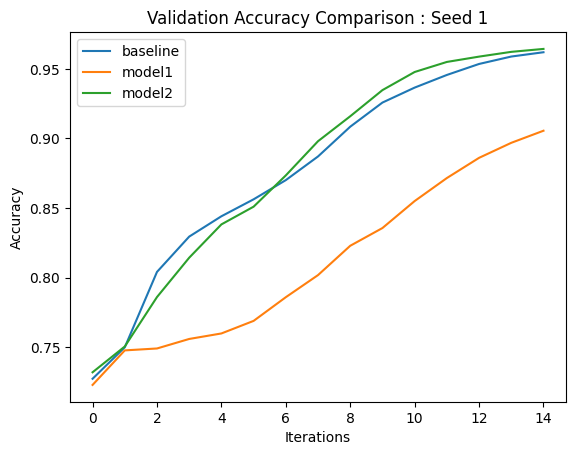

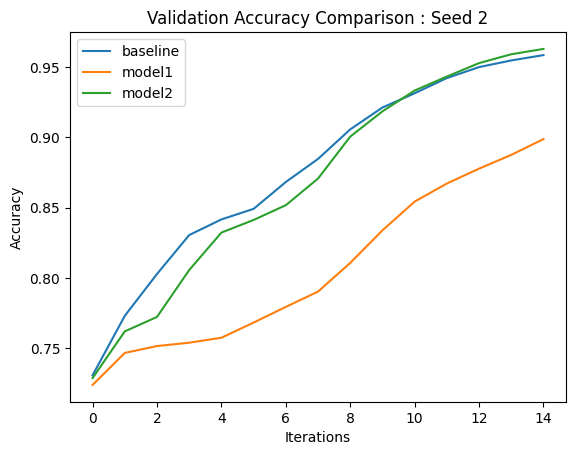

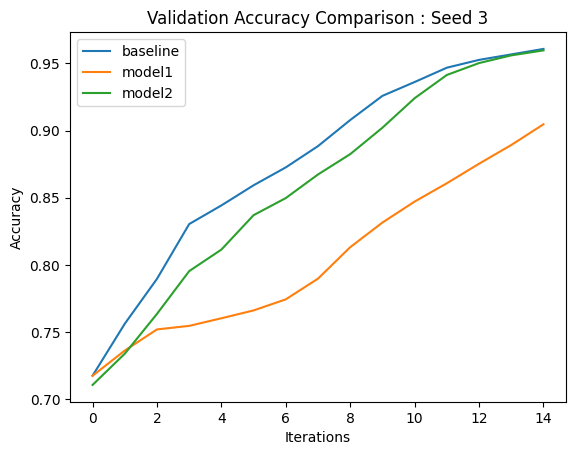

In [35]:
for seed in range(len(seeds)):
    for model in training_history:
        accuracy = training_history[model][seed]["val_accuracy"]
        plt.plot(range(len(accuracy)), accuracy, label=model)

    # Set common labels and title
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.title(f"Validation Accuracy Comparison : Seed {seeds[seed]}")

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()


### Other metrics


In [36]:
# Dictionary to hold all the details of each model
model_details = {}

for model_name in models_name:
    # Find the index of the seed with the best mean validation accuracy for this model
    seed_accuracies = [training_history[model_name][i]["val_accuracy"][-1] for i in range(len(seeds))]
    best_seed_index = np.argmax(seed_accuracies)

    # Store the best model details
    model_details[model_name] = {
        "model": models[model_name][best_seed_index],
        "history": training_history[model_name][best_seed_index],
        "mean_val_accuracy": np.mean(seed_accuracies),
        "std_val_accuracy": np.std(seed_accuracies),
        "best_val_accuracy": seed_accuracies[best_seed_index]
    }

#  The overall best model across all types
best_overall_model_name = max(model_details, key=lambda m: model_details[m]["mean_val_accuracy"])
best_overall_model_details = model_details[best_overall_model_name]

print(f"The best overall model is '{best_overall_model_name}' with a validation accuracy of {best_overall_model_details['mean_val_accuracy']:.2f}")

# Save the best overall model details in a separate variable
best_model_variable = best_overall_model_details


The best overall model is 'model2' with a validation accuracy of 0.96


In [37]:
#Best Model Metrics
best_model = best_model_variable['model']

metrics_val_best_model = metrics_by_pos(best_model, X=X_validation, Y=Y_validation, include_confusion_matrix=True)
metrics_test_best_model = metrics_by_pos(best_model, X=X_test, Y=Y_test, include_confusion_matrix=True)


#### Confusion Matrix

Here is a heatmap representation of the confusion matrix. You can choose if the matrix will be sorted by occurence of the POS or not. I think its better sorted because we don't care about a POS who appears really rarely.


In [38]:
import seaborn as sn
import matplotlib.pyplot as plt

def cm_heatmap(cm, size, title='Confusion Matrix', out_file=False, sorted=False, show=True):
    occurrence = cm.sum(axis=1, keepdims=True)
    lab = [idx_to_pos[val] for val in  metrics_val_best_model[2]]

    if sorted:
        # Sort the confusion matrix by the number of occurrence of the POS
        sorted_indices = np.argsort(occurrence, axis=0)[::-1].flatten()
        cm = cm[sorted_indices, :]
        cm = cm[:, sorted_indices]
        occurrence = occurrence[sorted_indices]

        lab = [lab[ind] for ind in sorted_indices]


    cm = cm/occurrence
    cm = cm[:size, :size] # Resize the confusion_matrix

    # Adjust the size of the heatmap
    plt.figure(figsize=(12, 7))

    # Set the font scale for both axis labels and annotations
    sn.set(font_scale=1.2)

    # Create the heatmap with annotations
    lab = lab[:size]
    sn.heatmap(cm, annot=True, cmap="Blues", cbar=False, annot_kws={"size": 5}, fmt='.1%', xticklabels=lab, yticklabels=lab)


    # Add row sums at the end of each row
    plt.text(size+1, size//2, "Occurence", va='center', ha='left', color='black', fontsize=12, rotation=270)

    for i, row_sum in enumerate(occurrence[:size]):
        plt.text(size, i+0.5, str(row_sum[0]), va='center', ha='left', color='black', fontsize=8)

    # Set axis labels and title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)

    # Save the heatmap as an image
    if out_file:
        plt.savefig(out_file, dpi=200)

    # Display the heatmap
    if show:
        plt.show()


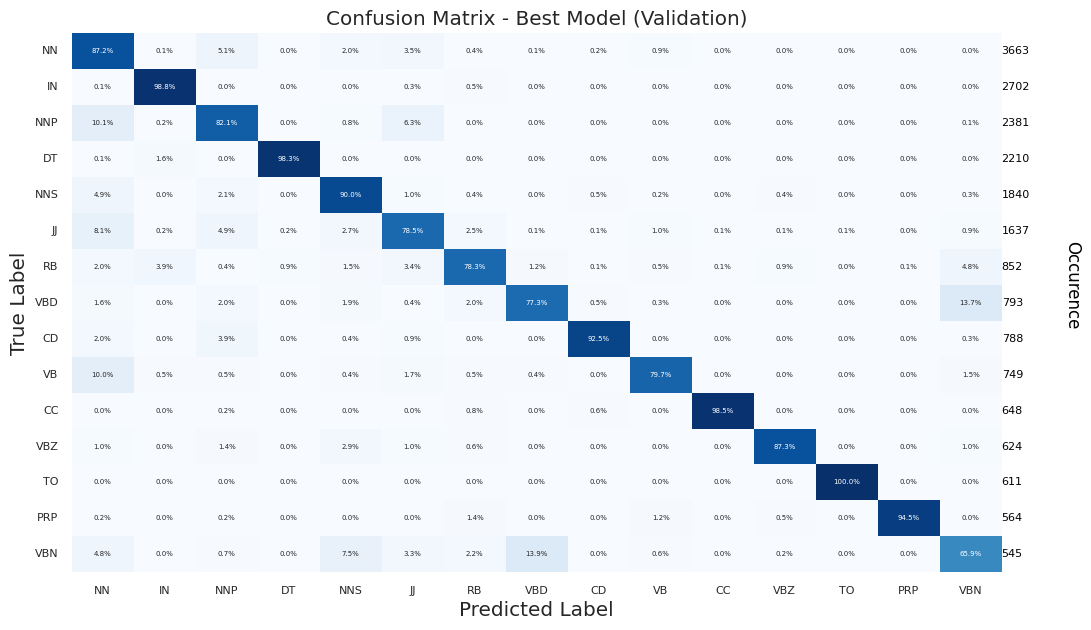

<Figure size 640x480 with 0 Axes>

In [39]:
# Confusion Matrix
cm_heatmap(cm=metrics_val_best_model[1], size=15, title="Confusion Matrix - Best Model (Validation)", sorted=True, show=True)

plt.savefig("best_model_cm_validation.png", dpi=200)
# Display the first plot and clear the plotting area for the next plot
plt.show()


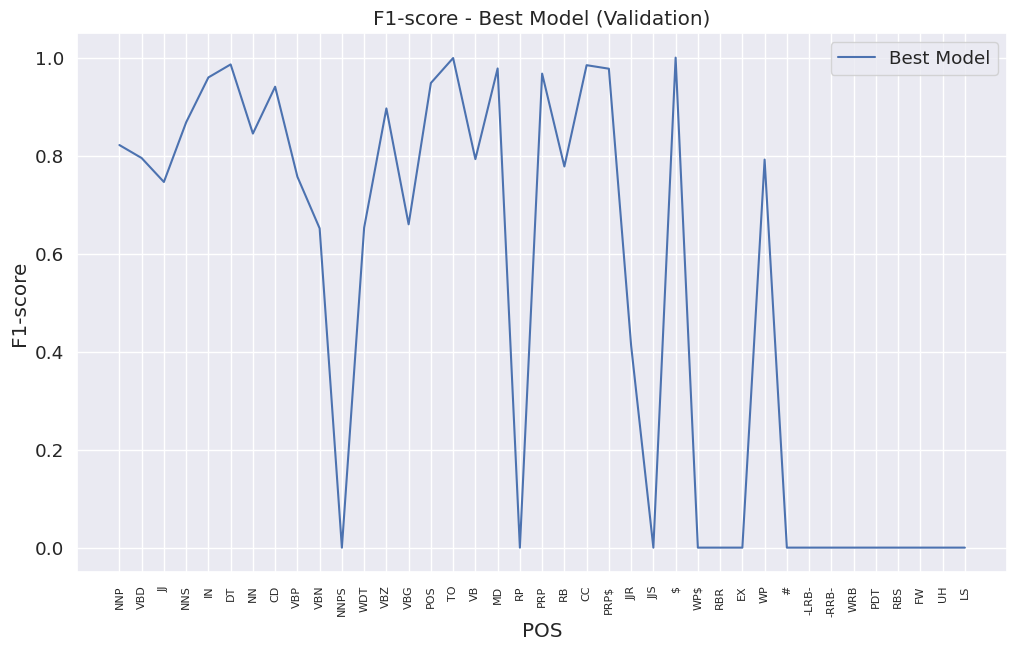

In [40]:
# Create a new figure for the F1-Score Plot
plt.figure(figsize=(12, 7))
plt.plot(metrics_val_best_model[0]["Word"], metrics_val_best_model[0]["F1-score"], label="Best Model")
plt.title('F1-score - Best Model (Validation)')
plt.xlabel('POS')
plt.ylabel('F1-score')
plt.xticks(rotation=90, fontsize=8)
plt.legend()

# Save the plot
plt.savefig("best_model_f1_score_validation.png", dpi=200)

# Display the second plot
plt.show()


In [41]:
# Function to compare F1-scores remains the same
def compare_f1_scores(metrics_val, metrics_test):
    comparison_df = pd.merge(metrics_val[0], metrics_test[0], on="Word", suffixes=('_val', '_test'))
    comparison_df['F1-diff'] = comparison_df['F1-score_test'] - comparison_df['F1-score_val']
    return comparison_df

# Compare F1-scores for the best model
comparison_best_model = compare_f1_scores(metrics_val_best_model, metrics_test_best_model)

# Print out the comparison DataFrame
print(comparison_best_model[['Word', 'F1-score_val', 'F1-score_test', 'F1-diff']])


     Word  F1-score_val  F1-score_test   F1-diff
0     NNP      0.821601       0.814242 -0.007359
1     VBD      0.795071       0.811908  0.016837
2      JJ      0.746225       0.775673  0.029448
3     NNS      0.867925       0.843158 -0.024767
4      IN      0.959569       0.951234 -0.008335
5      DT      0.986152       0.983598 -0.002554
6      NN      0.845015       0.847052  0.002037
7      CD      0.940645       0.932184 -0.008461
8     VBP      0.757021       0.736475 -0.020546
9     VBN      0.651543       0.643863 -0.007679
10   NNPS      0.000000       0.000000  0.000000
11    WDT      0.652850       0.647059 -0.005791
12    VBZ      0.896382       0.884368 -0.012013
13    VBG      0.659767       0.666667  0.006900
14    POS      0.948177       0.927273 -0.020904
15     TO      0.999182       0.998935 -0.000247
16     VB      0.792829       0.812834  0.020006
17     MD      0.977860       0.983683  0.005823
18     RP      0.000000       0.000000  0.000000
19    PRP      0.967

# Results: Our Model 2 performance is the best among the ones tested. The F1-scores seem good across most of the categories